<h1><center><span style="color:#C2571A"> Prediction of BMW used cars price </span></center></h1>

<h3><center> April 30, 2021 </center></h3>

<h3>Table of Contents </h3>
    
1. [Project Motivation](#1)
2. [The Dataset](#2)
3. [Machine learning algorithms](#3)
4. [Performance Metrics](#4)
5. [Read the dataset, conduct exploratory data analysis and clean the data](#6.1)
6. [Explore the data to discover any initial insights and perform transformations and/or feature engineering](#6.2)
7. [Preprocess data for modeling](#6.3)
8. [Test regression algorithms](#6.6)
9. [Tune model based on CatBoostRegression algorithm](#6.7)
10. [Implement BMW used cars predictor using CatBoostRegressor algorithm](#6.9)
11. [Conclusion and Recommendations](#7)
12. [References](#8)

## 1. Project Motivation <a name="1"></a>

What determines the price of used cars?

The value of a car drops right from the moment it is bought and the depreciation increases with each passing year. In fact, only in the first year, the value of a car can decrease from 10 to 60 percent (Ref. 1). 

Different factors affect the value of a vehicle such as the mileage, model, fuel type, the condition, location, color of a car, etc.

The goals of this projects are:
- explore what factors affect a sale price of used BMW cars and which characteristics are the most important to determine a car value,
- build a prototype of model which predicts price of used BMW cars.

The results of this project may be useful for businesses that work with reselling of used BWM cars and buyers who are looking to purchase a pre-owned BMW car. **Understanding the factors that determine the price and which of them have the biggest affect can help to improve the process of cars valuation.** On the one hand it can help to ensure the data with all important parameters is collected. On the other hand, it can help to save efforts on the initial steps of valuation, as only the most important car parameters can be collected to make a rough estimation of a car price or to assess how good is a particular deal of a car sale. 

**The developed sale price predictor can be of help during the process of cars search and valuation as it can be used as a tool that provides a quick rough estimation of a car price based on the given input parameters.**

## 2. The Dataset <a name="2"></a>

The dataset that was chosen for the analysis contains information about BMW Used Car Sales and was obtained from DataCamp GitHub repository for careerhub data (Ref. 2).

In the repository description or in the data itself there is no information about the source of this dataset, but there was a reference about the `tax` column as information about the road tax. Based on this an assumption was made that the data was collected in the United Kingdom.

This is related to the fact that miles per gallon parameter is commonly used only in three big countries: the United States, the United Kingdom and Canada. In the United States and Canada there is no road tax as such, but in the United Kingdom there is a road tax. The values of `tax` column in data set also correspond to tax rates in UK.

### 2.1. Dataset characteristics

The data consists of 10781 observations and 9 columns:
- 3 categorical variables: `model`, `transmission`, `fuelType`;
- 5 numerical variables: `year`, `engineSize`, `mileage`, `tax`, `mpg`;
- continuous target vatable `price`.


### 2.2. Context of the dataset 

Below are the general statistics of car market in UK, it can help during further analysis of factors that impact cars price.

According to the statistics from The Society of Motor Manufacturers and Traders (SMMT) in 2020 used car sales in UK decreased by 14.9% with the 6,753 thousands transactions made during the year(Ref. 6). In each quarter of 2020 the most popular BMW car was 3 Series model, which took 6th place by the number of transactions among all models os used cars sales. 

According to Statista data platform the BMW share in new cars market sales in UK was fluctuating from 5% to 9% during 2015-2020 (Ref. 7). In 2020 there were 115.5K new BMW passenger cars sold in UK, which is a decline of about 32% year-on-year amid the outbreak of the coronavirus pandemic (Ref. 8) - this is a significantly bigger decline in sales in comparison to used cars market decline.

Another interesting statistic is that as of 2016 the average age of cars on the road in the UK was 7.7 years old (Ref. 9).


## 3. Machine learning algorithms assumptions <a name="3"></a>

The task to be solved in this project is supervised regression problem.

Based on what is known at the moment about data characteristics a linear regression and random forest/gradient boosting algorithms may be suitable for this task. During data preparation and exploration we will take into account assumptions about input data that these algorithms have.

Linear regression may be quite powerful algorithm given the input data comply with following assumptions:  
-	linearity: assumes that the relationship between predictors and target variable is linear;
-	no noise: eg. that there are no outliers in the data;
-	no collinearity: if you have highly correlated predictors, it’s most likely your model will overfit;
-	normal distribution: more reliable predictions are made if the predictors and the target variable are normally distributed;
-	scale: it’s a distance-based algorithm, so preditors should be scaled (Ref. 10).

Random Forest algorithm on the other hand is less demanding as for the data preprocessing:
- the data does not need to be rescaled or transformed;
- algorithm is great with high dimensional data since it is working with subsets of data;
- algorithm is robust to outliers and non-linear data;
- problem of overfitting is frequently occur, can be solved with hyperparameters tuning.


## 4. Performance Metrics  <a name="4"></a> 

The choice of the best metric for regression task depends on specifics of the data and the requirements to the model performance.
For instance, what is more important: to predict price as accurate as possible on average or not to exceed certain threshold of acceptable error in predictions?

Based on what is known about the data at current stage and understanding of expectations from the model performance, it is suggested to use R-Squared/RMSE as the main metrics and MAE/RMSLE as the supporting metrics. This decision is based on the assumption that big errors in price predictions should be avoided, but in the same time accuracy of predictions is also should be measured. 

**R-Squared.** R-squared (R2) is a statistical measure, known as coefficient of determination, that represents the proportion of the variance for a dependent variable that is explained by an independent variable. R-squared metric determines goodness of fit and is scaled between 0 and 1. The advantage of this metric is ease of interpretation. 

**Root Mean Squared Error (RMSE).** RMSE is the most widely used metric for regression tasks and is the square root of the averaged squared difference between the target value and the value predicted by the model. It is preferred more in some cases because the errors are first squared before averaging which poses a high penalty on large errors. This implies that RMSE is useful when large errors are undesired. 

**Mean Absolute Error (MAE).** MAE is the absolute difference between the target value and the value predicted by the model. The MAE is more robust to outliers and does not penalize the errors as extremely as RMSE. MAE is a linear score which means all the individual differences are weighted equally.

**Root Mean squared logarithmic error (RMSLE).** Root mean squared logarithmic error can be interpreted as a measure of the ratio between the true and predicted values. In a simple words we can say that RMSLE only cares about the percentual difference and therefore is robust toward outliers as it scales down big errors nullifying their effect.

## 5. Read the dataset, conduct exploratory data analysis and clean the data <a name="6"></a>

In [836]:
# Import necessary libraries 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from patsy import dmatrices
import re
from termcolor import colored

from scipy import stats 
from scipy.stats import skew, chi2_contingency, norm
from scipy.special import inv_boxcox

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, ElasticNetCV, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import catboost as cat

from sklearn.metrics import make_scorer, explained_variance_score, mean_squared_error, mean_squared_log_error, mean_absolute_error
from yellowbrick.regressor import PredictionError, ResidualsPlot
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
#Set variable to set random state later in the project for results reproducibility 
seed=1

### 5.1 Read the data and check descriptive statistics

In [837]:
# Read dataset
data = pd.read_csv('bmw.csv')

# Print dataset statistics 
print('There are {} observations and {} columns in the DataFrame.'.format(data.shape[0], data.shape[1]))
print(colored('\n First 5 rows of the DataFrame:', attrs=['bold']))
display(data.head())
print('')
print(colored('Concise summary of the DataFrame:', attrs=['bold']))
print('')
display(data.info())
print('')
print(colored('Descriptive statistics of the numeric features:', attrs=['bold']))
display(data.describe())

There are 10781 observations and 9 columns in the DataFrame.

 First 5 rows of the DataFrame:


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0



Concise summary of the DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


None


Descriptive statistics of the numeric features:


,year,price,mileage,tax,mpg,engineSize
count,10781.000000,10781.000000,10781.000000,10781.000000,10781.000000,10781.000000
mean,2017.078935,22733.408867,25496.986550,131.702068,56.399035,2.167767
std,2.349038,11415.528189,25143.192559,61.510755,31.336958,0.552054
min,1996.000000,1200.000000,1.000000,0.000000,5.500000,0.000000
25%,2016.000000,14950.000000,5529.000000,135.000000,45.600000,2.000000
50%,2017.000000,20462.000000,18347.000000,145.000000,53.300000,2.000000
75%,2019.000000,27940.000000,38206.000000,145.000000,62.800000,2.000000
max,2020.000000,123456.000000,214000.000000,580.000000,470.800000,6.600000


### 5.2 Data cleaning

In [838]:
# Remove leading whitespaces from values in 'model' column
data['model'] = [i.strip() for i in data.model]

# There are only 3 cars with the value `Electric` for the `fuelType`, so we will merge this group with the `Other` `fuelType`
data.fuelType.replace('Electric', 'Other', inplace=True)
display(data.fuelType.unique())

array(['Diesel', 'Petrol', 'Other', 'Hybrid'], dtype=object)

From the statistics in step 1.1 we can see that there is no missing values in the dataset and data types are set correctly, but some features contain values that should be checked in more detail as there could be incorrect entries:
#### 1. `mileage` - min value 1. 
After filtering records with mileage<10, I got 67 observations of cars that were produced in years 2019 and 2020. We will assume that values are correct and these are very new cars that were nor used much
#### 2. `mpg` – min value: 5.5, max value: 470. 
>*Note*: for Hybrid Electric Vehicles `mpg` may be a lot higher. For this type of vehicles there is  a miles per gallon of gasoline-equivalent (MPGe) metric. We can think about it as parameter similar to MPG, but instead of presenting miles per gallon of the vehicle's fuel type, it represents the number of miles the vehicle can go using a quantity of fuel with the same energy content as a gallon of gasoline. (Ref. 12).

I reviewed observations with `mpg` below 20 and a pivot table with grouped average `mpg` for each `model` and `fuelType` and found that it’s necessary to check `mpg` for the models `3 Series`, `M6`, `X3` (for low `mpg` values) and `i3` (for very high `mpg` of 470).

-  `3 Series` model. The research showed that possible  `mpg` values are in the range from 27 to 217 mpg (Ref. 11).  So `mpg` value of 8.8 doesn't seem to be valid, let's replace it with average `mpg` for this model for `Hybrid` `fuelType`.
-  `M6` model. Official MPG for this model is in the range from 27.4 to 28.5, but there are claims that real MPG is in the range from 15 to 26 (Ref. 13). We will assume that the value of  19.1 is correct and will not make any replacements.  
-  `X3` model. From the research made for `mpg` values we conclude that `mpg` value of 5.5 is incorrect. Since there is no data for `X3` model with `Hybrid` `fuelType`, we will replace mpg value 5.5 with the average `mpg` for the closest model - `X5` model with `Hybrid` fuelType.
- `i3` model - official `mpg` is 149 (Ref. 14). We will assume that values of `mpg` above 400 are incorrect and will replace them. 

#### `engineSize` – min value 0.
The observations that have zero values for `engineSize` are:
-	`Petrol/Diesel` `fuelType` cars of  `1 Series`, `2 Series`, `3 Series`, `X5` model – there is an error as `engineSize` can not be equal to zero. We will replace `engineSize` values for these observations with the average `engineSize` for each model.
-	`Hybrid `/`Other` `fuelType` cars of `i3` model. This model may not have fuel engine (Ref. 14), so we will assume value 0 is valid.
>Note: model `i8`  can have a fuel engine, but it also has an electric engine, so it's not correct to compare engine size of electric cars with engine size of conventual fuel type cars. It was decided to create a new feature `engine_category` with the following values: `small_engine`, `medium_engine`, `big_engine`, `electric_engine`, it will categorize cars by engine size and separate cars of electric line.  

#### 5.2.1 Replace incorrect `mpg` values

In [839]:
# `3 Series` model, save average and replace low 'mpg' values
av_3_Series_2017 = data[(data.model.str.contains('3 Series'))&(data.year==2017)&
                         (data.fuelType=='Hybrid')].groupby('year')['mpg'].mean().iloc[0]

data.loc[(data.model.str.contains('3 Series'))&(data.mpg<10), 'mpg'] = av_3_Series_2017

# `X5` model,  save average and replace low 'mpg' values
avg_mpg_hybrid_X5 = data[(data.fuelType =='Hybrid')&(data.model.str.contains('X5'))]['mpg'].mean()
data.loc[(data.model.str.contains('X3'))&(data.fuelType=='Hybrid'), 'mpg'] = avg_mpg_hybrid_X5

# `i3` model, replace mpg above 400 with value of 149
data.loc[(data.mpg>400), 'mpg'] = 149

#### 5.2.2 Replace 0 values for `engineSize` for  models `1 Series`, `2 Series`, `3 Series`, `X5`

In [840]:
# Save average 'engineSize' values by 'model' in variables
avg_mpg_engine_1Series = data[(data.model.str.contains('1 Series'))]['engineSize'].mean()
avg_mpg_engine_2Series = data[(data.model.str.contains('2 Series'))]['engineSize'].mean()
avg_mpg_engine_3Series = data[(data.model.str.contains('3 Series'))]['engineSize'].mean()
avg_mpg_engine_X5 = data[(data.model.str.contains('X5'))]['engineSize'].mean()

# Replace 'engineSize' values
data.loc[(data.model.str.contains('1 Series'))&(data.engineSize<1), 'engineSize'] = avg_mpg_engine_1Series
data.loc[(data.model.str.contains('2 Series'))&(data.engineSize<1), 'engineSize'] = avg_mpg_engine_2Series
data.loc[(data.model.str.contains('3 Series'))&(data.engineSize<1), 'engineSize'] = avg_mpg_engine_3Series
data.loc[(data.model.str.contains('X5'))&(data.engineSize<1), 'engineSize'] = avg_mpg_engine_X5

##### 5.2.3 Create new feature `engine_category` with the following values: small_engine, medium_engine, big_engine, electric_engine

In [841]:
def create_engine_category (data=data):
    cut_bins = [-1, 0, 1.9, 2.9, 8]
    data['engine_category'] = pd.cut(data.engineSize, bins=cut_bins, 
                                 labels=["electric_line", "small_engine", "medium_engine", "big_engine"])
    data.loc[(data.model.str.contains('i3'))|(data.model.str.contains('i8')), 'engine_category'] = 'electric_line'
    data['engine_category'] = data.engine_category.astype('object')

In [842]:
create_engine_category()
display(data.groupby('engine_category')['model'].count())

engine_category
big_engine       2553
electric_line      60
medium_engine    6601
small_engine     1567
Name: model, dtype: int64

> Note: `engine_category` = `electric_line` defines cars models from the electric line of BMW.  It’s important to remember that cars in other model groups also can have plug-in hybrid petrol engines, but this is already described in ‘fuelType’ feature and only models ‘i3’ and ‘i8’ belong to dedicated electric cars model line. 

##  6. Explore the data to discover any initial insights and perform transformations and/or feature engineering <a name="6.2"></a>

In the prepared DataSet we have following features:
- 1 target continuous numerical variable: `price`;
- 4 categorical variables: `model`, `transmission`, `fuelType`, `engine_category`;
- 8 numerical variables: `year`, `mileage`, `tax`, `mpg`, `engineSize`, `top_speed`, `acceleration_min`, `engine_hp`.

Let's analyze these groups of variables one by one.

### 6.1 Analyze target variable `Price`

During modeling stage, we will try the linear regression algorithm, so let's check if target variable contains outliers and is normally distributed (we will calculate skewness for the target price and test the most common transformation methods to remove skewness).

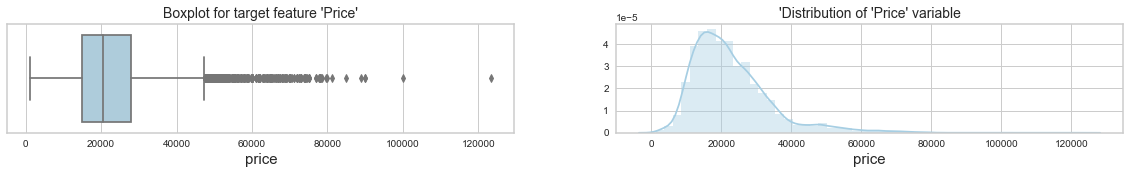

Skewnesss of 'Price' variable distribution before transformation is 1.59.


In [843]:
fig, axs = plt.subplots(ncols=2, figsize=(20,2))
sns.boxplot(data.price, ax=axs[0])
sns.distplot(data.price, kde=True,  ax=axs[1])
axs[0].set_title("Boxplot for target feature 'Price'", fontsize=14)
axs[1].set_title("'Distribution of 'Price' variable", fontsize=14)
plt.show()
print("Skewnesss of 'Price' variable distribution before transformation is {}.".format(round(skew(data.price),2)))

From the figures we can see that the target variable contains many outliers. Few of them, with price over 90K, are especially extreme. Sometimes removing outliers helps to improve the performance of Linear Regression algorithm, we will check this on the modeling stage. Also we can see that target variable is skewed to the right.

In [844]:
# Check log transformation for 'Price' variable to remove skewness
transformed = data['price']
data.loc[:, 'price_transformed'] = np.log(transformed)
print("Skewnesss of 'Price' variable after log transformation is {}."
      .format(round(skew(data.price_transformed),2)))

# Square Root Transform transformation for 'Price' variable to remove skewness
data['price_transformed'] = np.sqrt(transformed)
print("Skewnesss of 'Price' variable after Square Root transformation is {}."
      .format(round(skew(data.price_transformed),2)))

# BoxCox transformation
transformed = data['price']
data['price_transformed'] = stats.boxcox(transformed)[0]
box_cox_tranform_coef = stats.boxcox(transformed)[1]
print("Skewnesss of 'Price' variable after BoxCox transformation is {}."
      .format(round(skew(data.price_transformed),2)))

Skewnesss of 'Price' variable after log transformation is -0.24.
Skewnesss of 'Price' variable after Square Root transformation is 0.7.
Skewnesss of 'Price' variable after BoxCox transformation is 0.01.


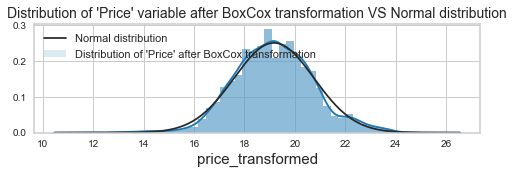

In [845]:
# BoxCox transformation gave the best results. Lets plot distribution of 'Price' variable after transformation
fig = plt.figure(figsize=(8,2))
sns.distplot(data.price_transformed,kde=True) 
sns.distplot(data.price_transformed, fit=stats.norm)
plt.title("Distribution of 'Price' variable after BoxCox transformation VS Normal distribution", fontsize=14)
plt.legend(labels=["Normal distribution","Distribution of 'Price' after BoxCox transformation"], loc ='upper left', fontsize=11)
plt.show()

Good! After transformation the new target variable `price_transformed` is almost normally distributed.  

### 6.2 Analyze correlation of price with categorical variables

#### 6.2.1 Analyze `model` feature

BMW grouping of Series and Models conventions (Ref. 15):
- Series with even numbers - sportier coupe-style vehicles (2 Series, 4 Series and 6 Series). The smaller is a number in Series - the smaller (and less expensive) is a vehicle. 
- Series with odd numbers - sedan-style vehicles (3 Series, 5 Series and 7 Series). The smaller is a number in Series - the smaller (and less expensive) is a vehicle. 
- X Models – SUVs and crossovers (or what BMW refers to as Sports Activity Vehicles and Sports Activity Coupes).
- Z Models – two door roadsters.
- M Models – high-performance version of many BMW models are grouped into the M Models (e.g. the M3 is a high-performance version of the 3 Series sedan). 'M' stands for Motorsport.
- i – electric and plug-in hybrid vehicles.

Let's add a new feature with model groups and look how it correlates with the price.

In [846]:
# Add model_group and model_series features

def create_model_group_and_series (data=data):
    # Extract letter and number from 'model' column
    data['model_group'] = [re.findall('[A-z]+', i)[0] for i in data.model]
    data['model_series'] = [re.findall('[0-9]+', i)[0] for i in data.model]
    data['model_series'] = data.model_series.astype('int')
    # Add 'coupe_style' and 'sedan_style' model groups
    data.loc[(data.model.str.contains('2 Series'))|
        (data.model.str.contains('4 Series')), 'model_group'] = 'coupe_style_small'
    data.loc[(data.model.str.contains('1 Series'))|
         (data.model.str.contains('3 Series')), 'model_group'] = 'sedan_style_small'
    data.loc[(data.model.str.contains('5 Series'))|
         (data.model.str.contains('6 Series')), 'model_group'] = 'sedan_coupe_mid_size'
    data.loc[(data.model.str.contains('8 Series')), 'model_group'] = 'coupe_big_size'
    data.loc[(data.model.str.contains('7 Series')), 'model_group'] = 'sedan_big_size'

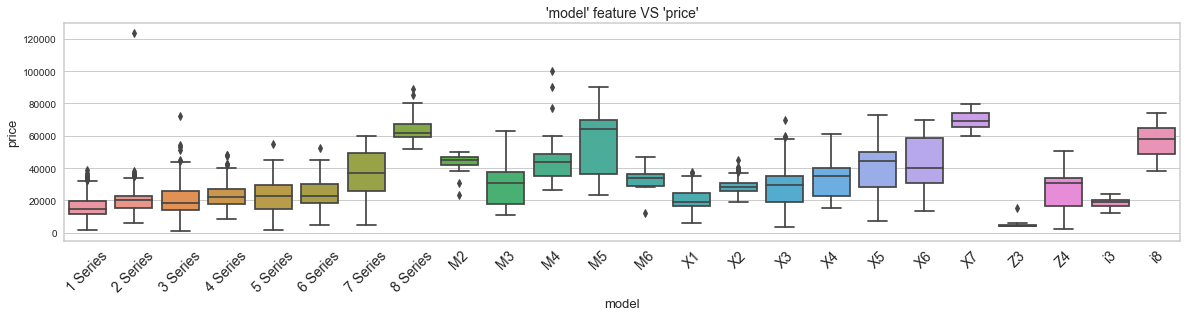

In [847]:
create_model_group_and_series()

plt.figure(figsize=(20,4))
ax = sns.boxplot(x='model', y='price', data=data.sort_values(by='model'))
ax.axes.set_title("'model' feature VS 'price'", fontsize=14)
ax.set_xlabel('model', fontsize=13)
ax.set_ylabel('price', fontsize=13)
ax.set_xticklabels(labels=data.sort_values(by='model').model.unique(), size=14, rotation=45)
plt.show()

`Model` feature seems to play important role in determining the car price. 

Almost for all model groups bigger cars seem to be more expensive with the exception of `M` model group. In this model group `M2` model on average is more expensive than `M3` and `M4`. Also `M6` model have surprisingly low price on average. 

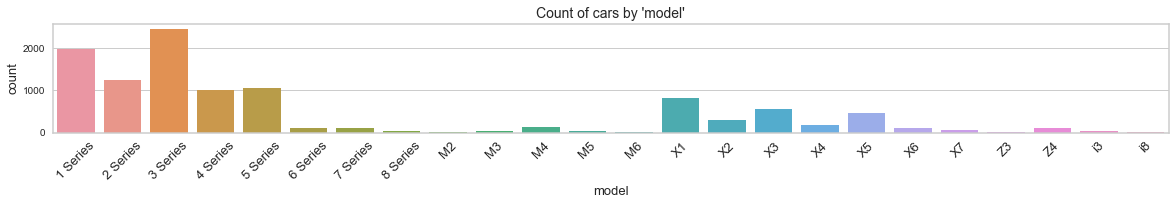

In [848]:
plt.figure(figsize=(20,2))
ax = sns.countplot('model', data=data.sort_values(by='model'))
ax.axes.set_title("Count of cars by 'model'", fontsize=14)
ax.set_xlabel('model', fontsize=13)
ax.set_ylabel('count', fontsize=13)
ax.set_xticklabels(labels=data.sort_values(by='model').model.unique(), size=13, rotation=45)
plt.show()

Interestingly, according to the statistics from The Society of Motor Manufacturers and Traders (SMMT) 3 Series model was the most frequently sold BMW car in UK in 2020. In our dataset number of sold `3 Series` models is also the biggest, but difference with count of sold `1 Series` models is not significant. 

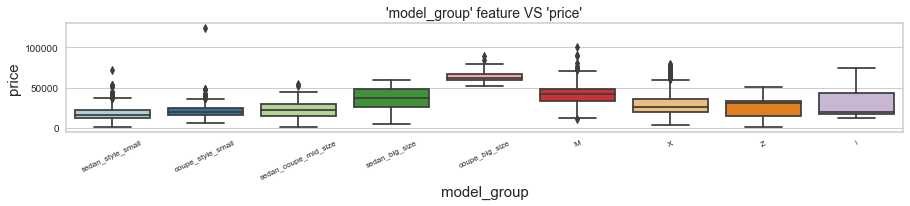

In [849]:
plt.figure(figsize=(15,2))
ax = sns.boxplot(x='model_group', y='price', data=data.sort_values(by='model'))
ax.axes.set_title("'model_group' feature VS 'price'", fontsize=14)
ax.set_xticklabels(labels=data.sort_values(by='model').model_group.unique(), size=8, rotation=25)
plt.show()

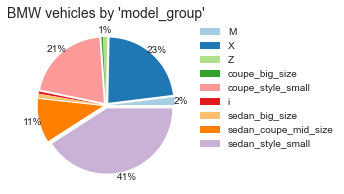

In [850]:
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > 1 else ''

sns.set_palette(sns.color_palette("Paired"))
labels, frequencies = np.unique(data.model_group.values, return_counts = True)
plt.figure(figsize = (3,3))
plt.pie(frequencies, labels = None, autopct = my_autopct, explode = ([0.05]*9), pctdistance = 1.1)
plt.title("BMW vehicles by 'model_group'", fontsize=14)
plt.legend(labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

From the figures we can see that smaller cars from `Series` grouping are the most popular ones (41% are sedan style and 21% coupe style, which gives significant 62% in total). These cars also have the lowest average price among other groups.

On the second place by popularity are SUVs and crossovers of `X` series which take share of 23%. On the third place by share are mid-size sedan type car of 5 Series model.

Electric (i models), performance (M models), roadsters (Z models) and big coupe style (6 Series   Series) vehicles take share of 5% in total. Cars from these groups have different distributions against price. What is interesting is that electric cars from of i series have pretty wide range in price (from 1595 to 88980) but median has pretty low value - 23980, so half of cars in this category have price below 23980.

#### 6.2.2 Analyze `fuelType` feature

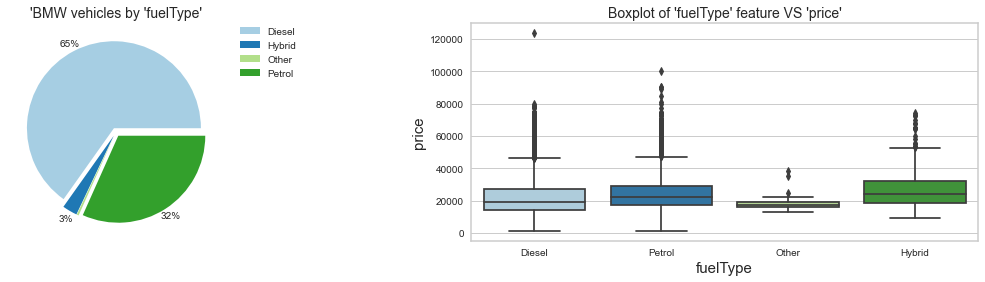

In [851]:
fig = plt.figure(figsize=(20,4))
ax1 = plt.subplot2grid((1,2),(0,0))
labels, frequencies = np.unique(data.fuelType.values, return_counts = True)
plt.pie(frequencies,labels = None, autopct = my_autopct, pctdistance = 1.1,  explode=([0.05]*4))
plt.legend(labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("'BMW vehicles by 'fuelType'",fontsize=14)

ax2 = plt.subplot2grid((1,2),(0,1))
sns.boxplot(x='fuelType', y='price', data=data)
plt.title("Boxplot of 'fuelType' feature VS 'price'", fontsize=14)
plt.show()

We can see for the figures that range of prices from 25 to 75 percentile for the cars with `Diesel`, `Hybrid` and `Petrol` engines does not differ much. Cars with `Other` fuel type have more narrow range, but it's less then 1% of cars of this category in the data. 

`fuelType` feature seems to not influence price much. In all plots we don’t see specific patterns of price correlation from `fuelType`.

#### 6.2.3 Analyze`transmission` feature

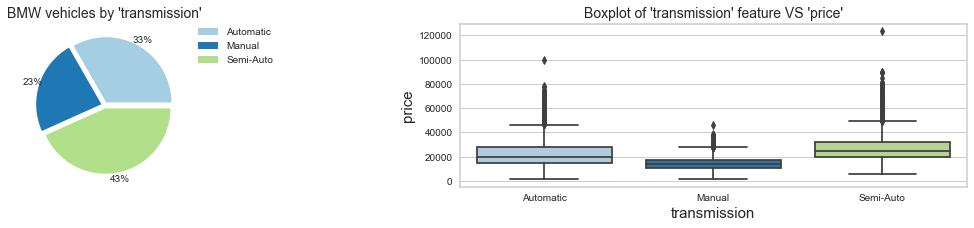

In [852]:
fig = plt.figure(figsize=(20,3))
ax1 = plt.subplot2grid((1,2),(0,0))
labels, frequencies = np.unique(data.transmission.values, return_counts = True)
plt.pie(frequencies,labels = None, autopct = '%1.0f%%', pctdistance = 1.1, explode=([0.05]*3))
plt.title("BMW vehicles by 'transmission'", fontsize=14)
plt.legend(labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax2 = plt.subplot2grid((1,2),(0,1))
sns.boxplot(x='transmission', y='price', data=data)
plt.title("Boxplot of 'transmission' feature VS 'price'", fontsize=14)
plt.show()

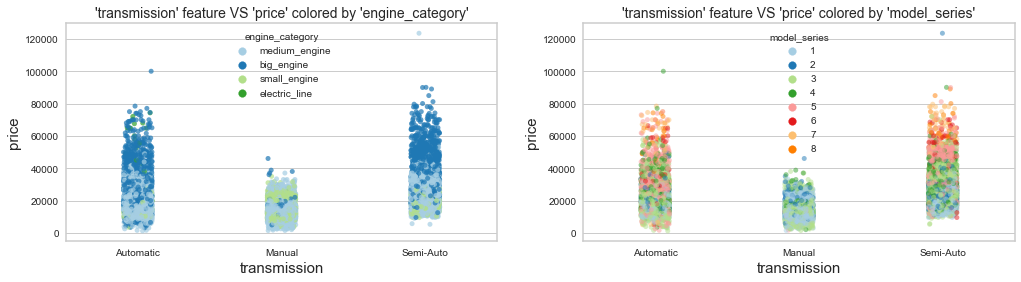

In [853]:
fig, axs = plt.subplots(ncols=2, figsize=(17,4))

sns.stripplot(x='transmission', y='price', data=data, hue='engine_category', alpha=0.7, ax=axs[0])
axs[0].set_title("'transmission' feature VS 'price' colored by 'engine_category'", fontsize=14)
sns.stripplot(x='transmission', y='price', data=data, hue='model_series', alpha=.5,  ax=axs[1])
axs[1].set_title("'transmission' feature VS 'price' colored by 'model_series'", fontsize=14)
plt.show()

Figures above confirms what we saw in the previous section, they show that `transmission` feature have an impact on price, cars with `Automatic` and `Semi-Auto` transmission have wider price range and on average tend to be more expensive than cars with `Manual` transmission. 

Also cars in a higher prices segment tend to belong to bigger models, have bigger engines and have `Automatic`/`Semi-Auto` transmission.

In [854]:
# Let's add boolean feature _big_engine_auto_or_semi_auto, maybe it can be useful on the modeling stage

def create__big_engine_auto_semi_auto (data=data):
    data.loc[(data.transmission!='Manual')&(data.engine_category=='big_engine'), '_big_engine_auto_semi_auto']='1'
    data._big_engine_auto_semi_auto.fillna(0, inplace=True)
    data._big_engine_auto_semi_auto=data._big_engine_auto_semi_auto.astype('int')
create__big_engine_auto_semi_auto()

#### 6.2.4 Analyze `engine_category` feature

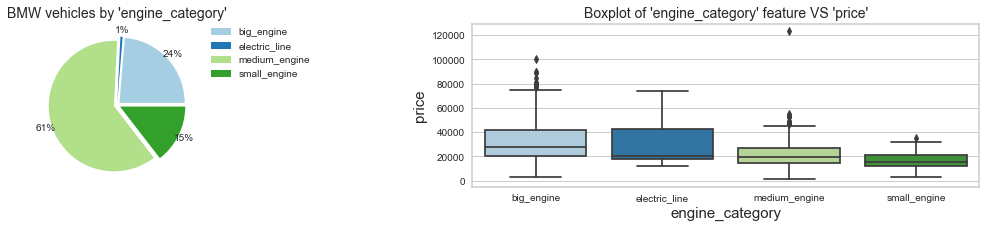

In [855]:
fig = plt.figure(figsize=(20,3))
ax1 = plt.subplot2grid((1,2),(0,0))
labels, frequencies = np.unique(data.engine_category.values, return_counts = True)
plt.pie(frequencies,labels = None, autopct = '%1.0f%%', pctdistance = 1.1, explode=([0.05]*4))
plt.title("BMW vehicles by 'engine_category'", fontsize=14)
plt.legend(labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax2 = plt.subplot2grid((1,2),(0,1))
sns.boxplot(x='engine_category', y='price', data=data.sort_values(['engine_category']))
plt.title("Boxplot of 'engine_category' feature VS 'price'", fontsize=14)
plt.show()

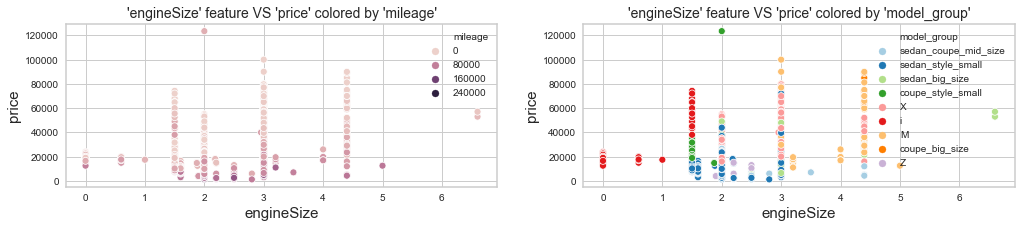

In [856]:
fig, axs = plt.subplots(ncols=2, figsize=(17,3))

sns.scatterplot(x='engineSize', y='price', data=data, hue='mileage', ax=axs[0])
axs[0].set_title("'engineSize' feature VS 'price' colored by 'mileage'", fontsize=14)

sns.scatterplot(x='engineSize', y='price', data=data, hue='model_group', ax=axs[1])
axs[1].set_title("'engineSize' feature VS 'price' colored by 'model_group'", fontsize=14)
plt.show()


We can see that price range varies depending of `engine_category` of a car, bigger is an engine - higher is an average price and wider is a price range becomes. But there are also cars with below average price among the ones with medium/big engines size, they tend to have high `mileage` values and belong to models groups `sedan_coupe_mid_size` and `sedan_style_small`.

#### 6.2.5  Correlation matrix for encoded categorical variables

In [857]:
categorical_without_model = pd.get_dummies(data[['transmission', 'fuelType', 'engine_category', 'model_group']], 
                                           drop_first=True)
categorical_model = pd.get_dummies(data.model, drop_first=True)

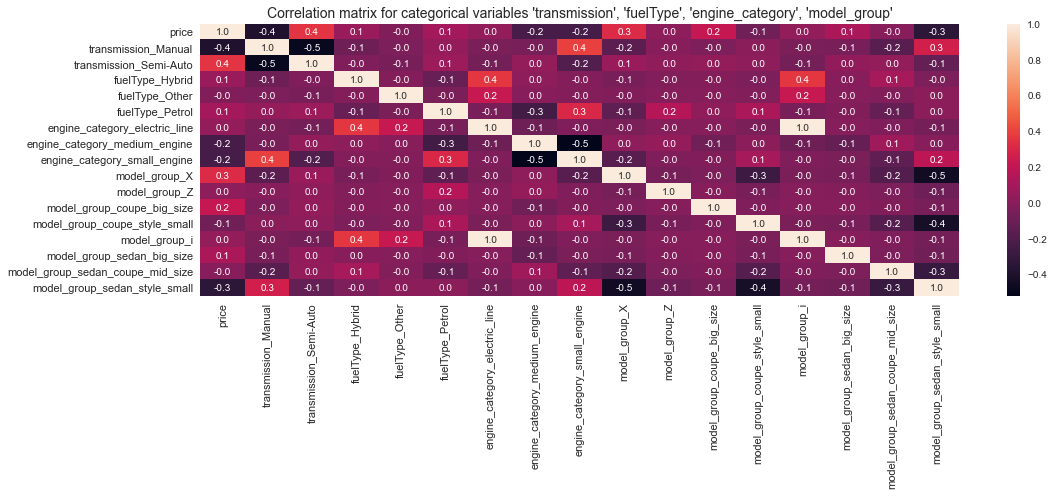

In [858]:
# Correlation matrix for categorical variables 'transmission', 'fuelType', 'engine_category', 'model_group'
plt.figure(figsize = (17,5))
corr_matrix = pd.concat([data.price, categorical_without_model], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, fmt = '.1f')
plt.title("Correlation matrix for categorical variables 'transmission', 'fuelType', 'engine_category', 'model_group'", 
          fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

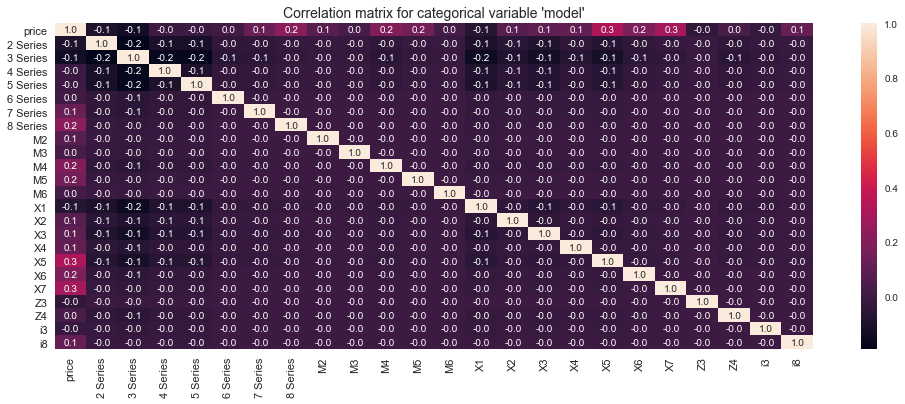

In [859]:
# Correlation matrix for categorical variable 'model'
plt.figure(figsize = (17,6))
corr_matrix = pd.concat([data.price, categorical_model], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, fmt = '.1f')
plt.title("Correlation matrix for categorical variable 'model'", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

From the correlation matrix we can see that some features do no not have correlation with the price. We need to pay attention to this on the modeling stage, test feature selection and regularization methods during model building. 

#### 6.2.6 Run 1-way ANOVA test for categorical variables

Since there is no correlation to price of quite a few encoded categorical variables, let’s check if there is a statistically significant difference in price for cars grouped by each categorical variable.

The null hypothesis for this test is that difference in mean price by group is statistically significant (variation in price between different groups can be a random noise due to the sampling effect).

In the results of this test we will compare the p-value to our chosen alpha. As a rule of thumb in our case we will choose alpha=0.05. If our p-value is smaller than 0.05, then we can reject the null hypothesis in favor of the alternative: this means that at least one group price mean is significantly different. If our p-value is larger than 0.05, then we cannot reject our null hypothesis and we cannot accept our alternative.

In [860]:
categorical_columns=['model', 'transmission', 'fuelType', 'engine_category', 'model_group']
for i in categorical_columns:
    lm = ols('price_transformed~{}'.format(i), data=data).fit()
    print('')
    print(colored("Results of 1-way ANOVA test for '{}' variable:".format(i), attrs=['bold']))
    table = sm.stats.anova_lm(lm)
    display(table)
    if table['PR(>F)'][0] <0.05:
        print("We can reject the null hypothesis for '{}' variable. At least one '{}' group mean in price is significantly different.".format(i, i))
    else:
        print("We cannot reject null hypothesis and we cannot accept the alternative for '{}' variable.".format(i))


Results of 1-way ANOVA test for 'model' variable:


,df,sum_sq,mean_sq,F,PR(>F)
model,23.0,9980.792999,433.947522,269.950435,0.0
Residual,10757.0,17291.965059,1.607508,NaN,NaN


We can reject the null hypothesis for 'model' variable. At least one 'model' group mean in price is significantly different.

Results of 1-way ANOVA test for 'transmission' variable:


,df,sum_sq,mean_sq,F,PR(>F)
transmission,2.0,6969.273473,3484.636737,1849.801427,0.0
Residual,10778.0,20303.484584,1.883790,NaN,NaN


We can reject the null hypothesis for 'transmission' variable. At least one 'transmission' group mean in price is significantly different.

Results of 1-way ANOVA test for 'fuelType' variable:


,df,sum_sq,mean_sq,F,PR(>F)
fuelType,3.0,518.542223,172.847408,69.625532,1.370200e-44
Residual,10777.0,26754.215834,2.482529,NaN,NaN


We can reject the null hypothesis for 'fuelType' variable. At least one 'fuelType' group mean in price is significantly different.

Results of 1-way ANOVA test for 'engine_category' variable:


,df,sum_sq,mean_sq,F,PR(>F)
engine_category,3.0,5152.815296,1717.605099,836.82993,0.0
Residual,10777.0,22119.942761,2.052514,NaN,NaN


We can reject the null hypothesis for 'engine_category' variable. At least one 'engine_category' group mean in price is significantly different.

Results of 1-way ANOVA test for 'model_group' variable:


,df,sum_sq,mean_sq,F,PR(>F)
model_group,8.0,6271.224516,783.903065,402.075581,0.0
Residual,10772.0,21001.533541,1.949641,NaN,NaN


We can reject the null hypothesis for 'model_group' variable. At least one 'model_group' group mean in price is significantly different.


From the results 1-way ANOVA test we can conclude that in each variables at least on group have statistically significant impact on the price.
The most important features according to F-value (statistic value for significance of adding model terms) are: 
- `transmission` (F=1851),
- `engine_category`(F=836),
- `model_group`(F=445).

### 6.3 Analyze correlation of `price` with numerical variables

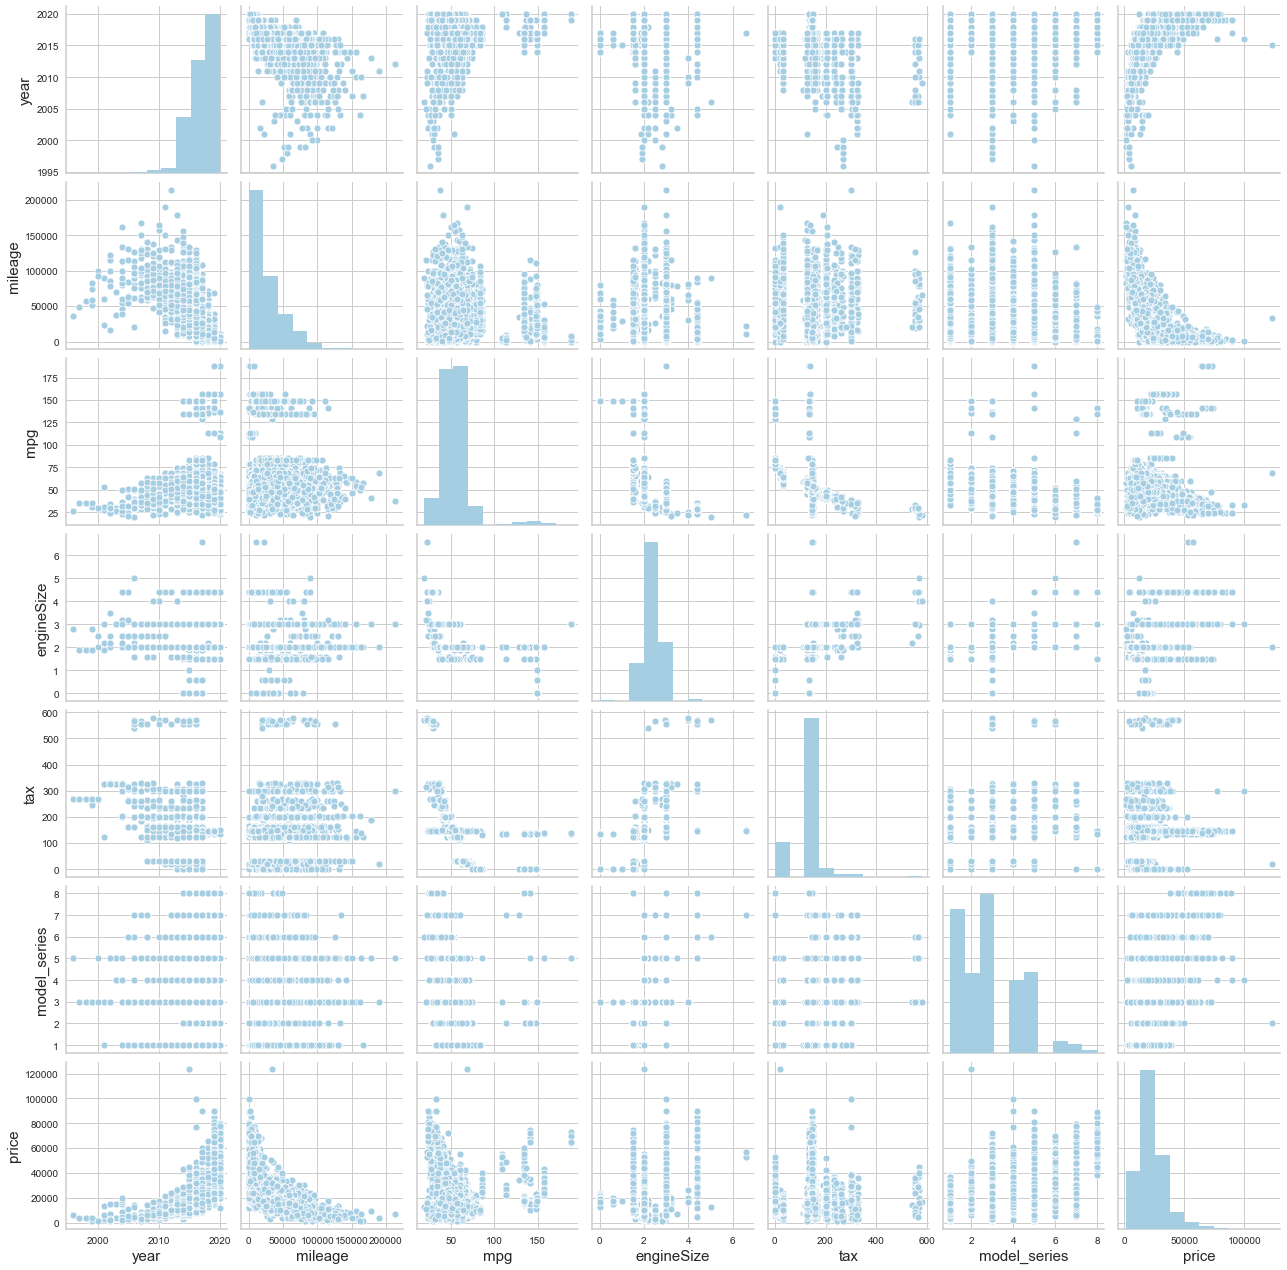

In [861]:
# Explore pairplot for numerical variables from the initial data: 'year', 'mileage', 'mpg', 'engineSize', 'price'
sns.pairplot(data[['year', 'mileage', 'mpg', 'engineSize', 'tax', 'model_series', 'price']])
plt.show()

From the plot we can see that there is:
- pretty strong correlation between `price` and `year`/`mileage` variables. In the same time `mileage` seem to have strong negative correlation with the `year`, which makes sense: the older car is - the higher is average mileage. Relationship of `year` and `price` variables can be described as an exponential function and between `mileage` and `price` as an inverse square function.
- there is also a moderate correlation between the `price` and `mpg`/`engineSize` variables. 
- as for `tax` feature - we can't see a pattern on how `tax` affect price, if there is a relationship between road tax and price - it`s non-linear.

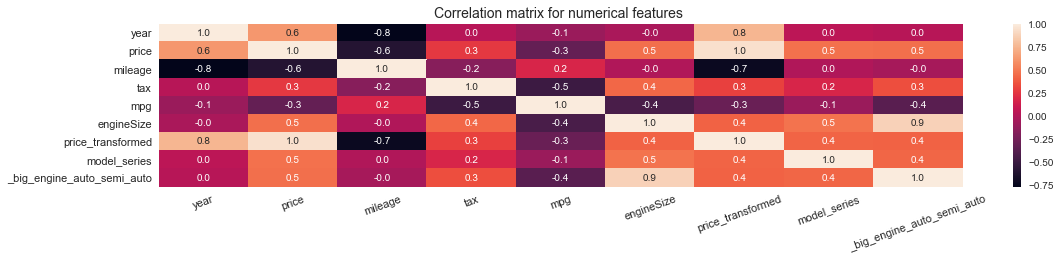

In [862]:
# Check correlation matrix 
corr_matrix = data.corr()
plt.figure(figsize=(18,3))
plt.title('Correlation matrix for numerical features ', fontsize=14)
fig = sns.heatmap(corr_matrix, annot=True, fmt = '.1f')
plt.xticks(fontsize=11, rotation=20)
plt.yticks(fontsize=11)
plt.show()

From the plot above we can see that all numerical features are moderately correlated with the target variable price.
- the highest correlation of `price` is with `year`, `mileage` features (0.6 and -0.6 coefficients);
- `engineSize`, `model_series` and `_big_engine_auto_semi_auto` have a a bit lower correlation (0.5 coefficients);
- `mpg` and `tax` features have the lowest correlation with the `price` (-0.3 and 0.3 coefficients) - probably lower correlation coefficient for these features is connected to the fact that relation is not linear.

Independent variables `year` and  `mileage`, `_big_engine_auto_semi_auto` and `engineSize` have strong correlation between each other. To check correlation between explanatory variables I calculated `variance_inflation_factor` for all numeric features and it was 2.7 for `mileage` and 5.3 for `EngineSize`.  A value greater than 5 indicates potentially severe correlation between a given explanatory variable and other explanatory variables in the model, so potentially there is multicollinearity problem for `EngineSize` feature, especially considering that model did not include  `Engine category` feature.

#### 6.3.1 Analyze `year` feature

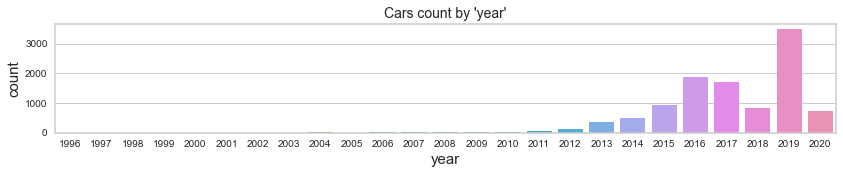

In [863]:
plt.figure(figsize = (14,2))
sns.countplot(data.year)
plt.title("Cars count by 'year'", fontsize=14)
plt.show()

Most cars in our dataset is pretty new, which make sense since average age of cars on the road in the UK was 7.7 years old in 2016.

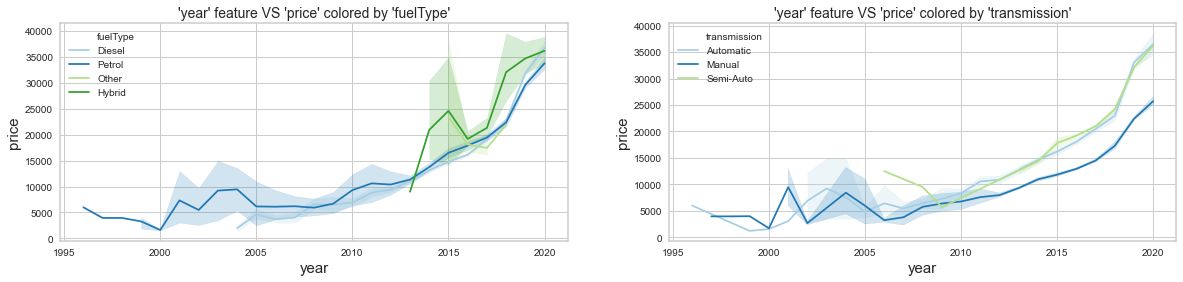

In [864]:
fig, axs = plt.subplots(ncols=2, figsize=(20,4))

sns.lineplot(x='year', y='price', data=data, hue='fuelType', ax=axs[0])
axs[0].set_title("'year' feature VS 'price' colored by 'fuelType'", fontsize=14)

sns.lineplot(x='year', y='price', data=data, hue='transmission', ax=axs[1])
axs[1].set_title("'year' feature VS 'price' colored by 'transmission'", fontsize=14)

plt.show()

Cars that are 10 years old or newer have tendency to have higher price for newer cars. As for older cars (10 years old and more) - correlation between `year` and `price` doesn't seem to be strong (on average cars 2001-2015 even have higher prices than cars from 2005-2010).

First figure shows that the `Hybrid` fuel type cars that are presented in the data were all produced in 2013 or later and tend to be more expensive on average in comparison to other fuel types cars.

The second figure shows that `transmission` type doesn’t have much impact for older cars (from 2010 and older), while newer cars with `Automatic` and `Semi-auto` transmission tend to be more expensive than the ones with `Manual` transmission.

Looks like features affect pricing of cars differently for the older cars (from 2010 and older) and for the newer cars (newer than 2010). Let's use the average age of cars in UK as a threshold to introduce a new boolean feature `_not_old_car`.

In [865]:
# Add feature '_not_old_car' for cars produced after 2013

def create__not_old_car (data=data):
    data.loc[(data.year>2013), '_not_old_car']='1'
    data._not_old_car.fillna(0, inplace=True)
    data._not_old_car=data._not_old_car.astype('int')
create__not_old_car()

#### 6.3.2 Analyze `mileage` feature

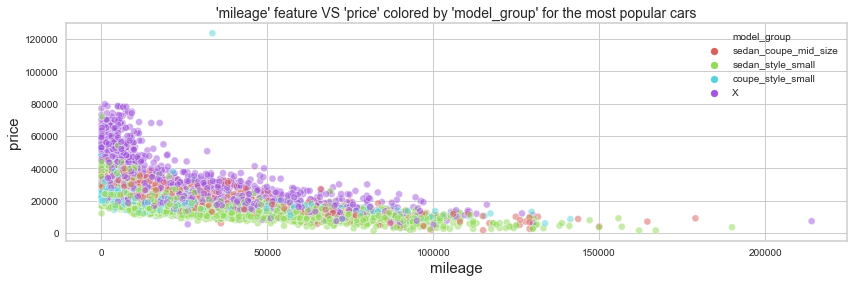

In [866]:
plt.figure(figsize=(14,4))
most_popular_cars = data[data.model_group.isin(['sedan_style_small', 'coupe_style_small', 'sedan_coupe_mid_size', 'X'])]
popular_cars_colors = sns.color_palette("hls", 4)

sns.scatterplot(x='mileage', y='price', data=most_popular_cars, hue='model_group', alpha=0.5, palette = popular_cars_colors )
plt.title("'mileage' feature VS 'price' colored by 'model_group' for the most popular cars", fontsize=14)
plt.show()

In [867]:
# The value of price >  100K for `coupe_style_small` car looks not right, let’s replace it with the mean. 
mean_price_2Series = data[(data.model=='2 Series')&(data.year==2015)&(data.engine_category=='medium_engine')&
     (data.transmission=='Semi-Auto')&(data.price<90000)]['price'].mean()
data.loc[3638, 'price'] = mean_price_2Series

To improve readability only data for the most popular model groups was selected and plotted. Figure shows that selected model seem to be groups are in different price segments and there is a visible correlation of `mileage` and `price` variables  within the model groups.

#### 6.3.3 Analyze `mpg` feature

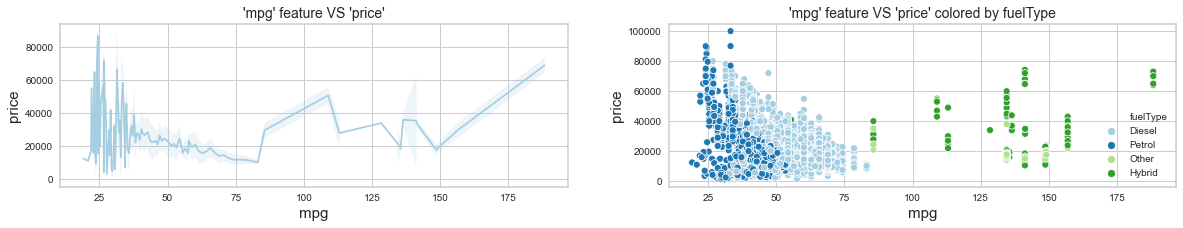

In [868]:
fig, axs = plt.subplots(ncols=2, figsize=(20,3))

sns.lineplot(x='mpg', y='price', data=data, ci='sd', ax=axs[0])
axs[0].set_title("'mpg' feature VS 'price'", fontsize=14)

sns.scatterplot(x='mpg', y='price', data=data, ci='sd', hue='fuelType', ax=axs[1])
axs[1].set_title("'mpg' feature VS 'price' colored by fuelType", fontsize=14)

plt.show()

From the plots we can see that there is a non-linear relationship between `mpg` and `price`.

- For `fuelType` = `Diesel` there seem to be a negative correlation: bigger `mpg` - lower the price,
- For `fuelType` = `Petrol` there is also a negative correlation of `mpg` and `price` features, that is even stronger that for `Diesel` fuelType.
- For `fuelType` = `Hybrid` and `Other` and mpg below 149 - there seem to be no correlation of `mpg` value and price.

Let's create 2 new features derived from `mpg` feature to reflect found pattern. 

In [869]:
# Add 2 new features derived from 'mpg' feature
def create_mpg_1_and_mpg_2 (data=data):
    data.loc[data.fuelType=='Petrol', 'mpg_1'] = data.mpg
    data.loc[data.fuelType=='Diesel', 'mpg_2'] = data.mpg
    data.replace(np.nan, 0, inplace=True)
create_mpg_1_and_mpg_2()

#### 6.3.4 Analyze `tax` feature 

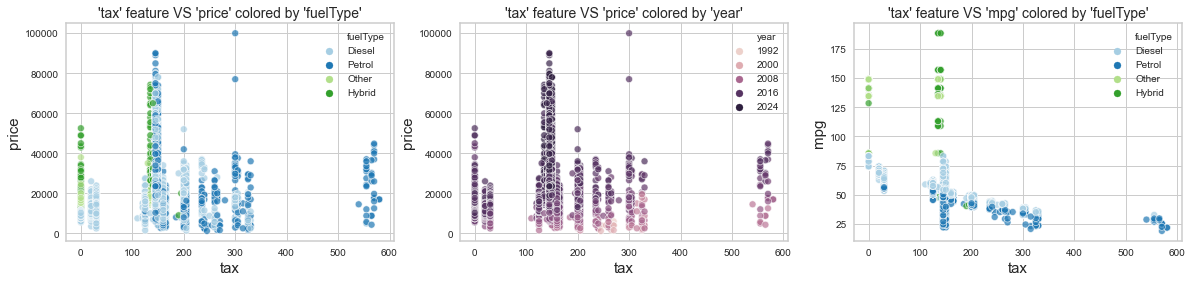

In [870]:
fig, axs = plt.subplots(ncols=3, figsize=(20,4))

sns.scatterplot(x='tax', y='price', data=data, hue='fuelType', alpha=0.7, ax=axs[0])
axs[0].set_title("'tax' feature VS 'price' colored by 'fuelType'", fontsize=14)

sns.scatterplot(x='tax', y='mpg', data=data, hue='fuelType', alpha=0.7, ax=axs[2])
axs[2].set_title("'tax' feature VS 'mpg' colored by 'fuelType'", fontsize=14)

sns.scatterplot(x='tax', y='price', data=data, hue='year', alpha=0.7, ax=axs[1])
axs[1].set_title("'tax' feature VS 'price' colored by 'year'", fontsize=14)

plt.show()

From the plots we can see that there is no strong correlation between `tax` feature and `price`. The first figure shows that cars with `Hybrid` and `Other` fuel types have lower or no tax which was expected. 

The second figure shows that older cars tend to have higher road taxes, but surprisingly some relativity new cars are in the cluster with the highest tax rate (>500), these cars also have very low `mpg` values.

The last figure shows that there is a linear relation between `tax` and `mpg` variables: the lower the `mpg` - the higher the `tax`, cars with alternative `fuelType` have especially high `mpg`.

#### 6.3.5 Analyze  `model_series` feature

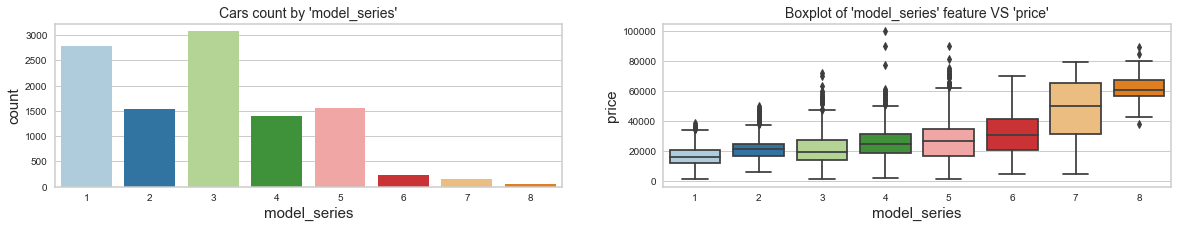

In [871]:
fig, axs = plt.subplots(ncols=2, figsize=(20,3))

sns.countplot(data.model_series, ax=axs[0])
axs[0].set_title("Cars count by 'model_series'", fontsize=14)

sns.boxplot(x='model_series', y='price', data=data, ax=axs[1])
axs[1].set_title("Boxplot of 'model_series' feature VS 'price'", fontsize=14)

plt.show()

From the figures we can see that `model_series` feature has moderate correlation with `price`: bigger models tend to have higher price. What is interesting that among bigger models there are still cheap options. 

### 6.4 Summary 

**Target variable `price`.**
-	We applied Box-Cox transformation, so now variable `price_transformed` has almost normal distribution,
-	`Price` contains a lot of outliers, possibly removing them can improve model performance when using Liner Regression.

**Categorical variables `model`, `model_group`, `transmission`, `fuelType`, `engine_category`.**
- we extracted features `model_group` and `model_series` from `model`,
- during analyzing `engine_category` feature we found that cars with bigger engines tend to have higher price. But there are also cars with price below average among the ones with medium/big engines size, they tend to have high `mileage` values and belong to models groups `sedan_coupe_mid_size` and `sedan_style_small`.
- for all categorical features at least one group has statistically significant impact on the price. But in correlation matrix we saw that relation of a car to some of models/model groups doesn't correlate with the price, so we will check if it’s better to remove them on the modeling stage.
- the most important features according to F-value are `transmission` (F=1851), `engine_category`(F=836), `model_group`(F=445).

**Numerical variables: `year`, `mileage`, `tax`, `mpg`, `engineSize`, `model_series`.**
-	`Year` and `mileage` features have the strongest correlation with price:

    - newer cars tend to have higher price, especially with `Hybrid` fuel type and `Automatic`/`Semi-Auto` transmission. We have relativly new cars in the dataset (from 2013 and newer). Correlation of `year` to `price` seem to be stronger for newer cars, so new boolean feature `_not_old_car` is added (for cars produced in 2013 or later).
    - different model lines seem to be in different price segments and there is a visible correlation of `mileage` and `price` within model groups.

-	`engineSize` and `model_series` features have moderate correlation with price.
    
-	`mpg` and `tax` features have the lowest correlation with the price due to non-linear dependency.  
    -	as for `mpg` feature there is a pattern of it's correlation to price depending on `fuelType`: 
        - for `Petrol`/`Diesel` fuel type cars there is a moderate negative correlation of `mpg` feature and price, 
        - for cars with `Hybrid`/`Other` fuel type - there is almost no correlation woth `price`. 
    -  There is a weak correlation between price and tax rate. Another finding is that `tax` feature is correlated with `mpg` and also older cars seem to have higher tax rates.

## 7. Preprocess data for modeling <a name="6.3"></a>

In [872]:
# Split data to train and test sets
train_df, test_df = train_test_split(data, 
                                     test_size=0.2, 
                                     random_state=seed, 
                                     stratify=data[["model"]])

In [873]:
# Separate features and target
y_train = train_df['price_transformed']
X_train_df = train_df.drop(['price', 'price_transformed'], axis=1)
X_test_df = test_df.drop(['price', 'price_transformed'], axis=1)
y_test = test_df['price_transformed']

In [874]:
# Standardize the data: StandardScaler for numerical features and OneHotEncoding for categorical features
scaler=StandardScaler()
encoder = OneHotEncoder(drop='first')
X_train_num =  scaler.fit_transform(X_train_df.select_dtypes(exclude='object'))
X_test_num = scaler.transform(X_test_df.select_dtypes(exclude='object'))
X_train_cat = encoder.fit_transform(X_train_df.select_dtypes(include='object'))
X_test_cat = encoder.transform(X_test_df.select_dtypes(include='object'))

# Combine preprocces features 
X_train = np.concatenate((X_train_num, X_train_cat.toarray()), axis=1)
X_test = np.concatenate((X_test_num, X_test_cat.toarray()), axis=1)

## 8. Test regression algorithms <a name="6.6"></a>

In this section we will train models using algorithms described in item '3. Machine learning algorithms' and check the results.

In [875]:
# Initiate regression models
KNeighbors = KNeighborsRegressor(n_neighbors=3)
lin_reg = LinearRegression()
SGD = SGDRegressor(random_state = seed)
GBR = GradientBoostingRegressor(random_state = seed)
elasticNet = ElasticNetCV(random_state = seed)
DecisionTree = DecisionTreeRegressor(random_state = seed)
RandomForest = RandomForestRegressor(n_estimators = 10, random_state = seed)
SVR_reg = SVR(kernel = 'rbf')
AdaBoost = AdaBoostRegressor(random_state = seed)
XGBR = XGBRegressor(random_state = seed)
lgb_reg = lgb.LGBMRegressor(random_state = seed)
cat_reg = cat.CatBoostRegressor(random_state = seed, loss_function='RMSE', silent=True)

models=[lin_reg, SGD, elasticNet, KNeighbors, SVR_reg, DecisionTree, RandomForest, GBR, AdaBoost, XGBR, lgb_reg, cat_reg]

In [877]:
# Define a function to print metrics 
def calculate_metrics(y_pred, model, y=y_test, printing=True):
    explained_variance = round(explained_variance_score(y, y_pred),4)
    MAE = round(mean_absolute_error(y, y_pred),4)    
    RMSE = round(np.sqrt(mean_squared_error(y, y_pred)),4)
    MSLE = round(mean_squared_log_error(y, y_pred),6)
    if printing==True:
        print("Results of {} model: \n - explained_variance: {},".format(model, explained_variance))
        print(" - mean_absolute_error: {}, \n - root_mean_squared_error: {}, \n - mean_squared_log_error: {}."
                                                                                      .format(MAE, RMSE, MSLE))
    else:
        metrics = [model, explained_variance, MAE, RMSE, MSLE]
        return metrics

In [878]:
def create_dataframe_with_predictions(model, X_test, box_cox_tranform_coef = box_cox_tranform_coef):
    """
Parameters expected by the function:
    - model – instance of model to apply to make predictions,
    - name_of_dataframe – defines the name of new dataframe that will be created, dataframe will contain X_test_df features, Real and Precited prices in absolute values. 
    - box_cox_tranform_coef - coefficient for price transformation, default value is variable box_cox_tranform_coef.
Function also prints statistics for '%error' column, calculates % of prices with error >25%, calculates and prints metrics of model performance: explained_variance, MAE, RMSE, MSLE
    """
    # Inverse BoxCox transformation for the price 
    y_pred_price_by_model = inv_boxcox(model.predict(X_test), box_cox_tranform_coef)
    # Create a table with real price, predicted price and features 
    dataframe = pd.concat([pd.DataFrame(y_test_price).reset_index(drop=True), 
                       pd.DataFrame(y_pred_price_by_model), 
                       X_test_df.reset_index(drop=True)], axis=1)
    dataframe.columns=['Real_price', 'Predicted_price']+[i for i in X_test_df.columns]
    dataframe['%error'] = abs(dataframe.Real_price - dataframe.Predicted_price)/dataframe.Real_price
    print('DataFrame with price predictions is created.')
    print('There are {}% of predictions  with error > 25%.'
          .format(round(dataframe[dataframe['%error']>0.25]['%error'].count()/dataframe['%error'].count(),4)*100))
    print('')
    # Calculate  metrics
    calculate_metrics(y_pred=y_pred_price_by_model, model=model, y=y_test_price)
    return(dataframe)

In [882]:
# Fit Regressors and print performance results 
results={}
for i in models:
    i.fit(X_train, y_train)
    y_pred_reg = i.predict(X_test)
    result = calculate_metrics(y_pred=y_pred_reg, model=i, y=y_test, printing=False)
    results[str(result[0]).split('(')[0]] = result[1:]
display(pd.DataFrame.from_dict(results, orient='index', columns = ['R2', 'MAE', 'RMSE', 'MSLE']))

,R2,MAE,RMSE,MSLE
LinearRegression,0.9367,0.2935,0.3937,0.000388
SGDRegressor,0.9005,0.3445,0.4938,0.000607
ElasticNetCV,0.9316,0.3018,0.4093,0.000418
KNeighborsRegressor,0.9450,0.2538,0.3672,0.000348
SVR,0.9494,0.2443,0.3523,0.000315
DecisionTreeRegressor,0.9289,0.2855,0.4173,0.000449
RandomForestRegressor,0.9514,0.2371,0.3449,0.000311
GradientBoostingRegressor,0.9454,0.2726,0.3657,0.000340
AdaBoostRegressor,0.8442,0.5164,0.6552,0.001074
XGBRegressor,0.9604,0.2228,0.3116,0.000253


From the results we can see that CatBoost and XGBoost algorithms have the best performance.
Since CatBoostRegressor has the lowest loss, we will explore it in more detail. CatBoost is a relatively new open-source machine learning algorithm that was built upon the theory of decision trees and gradient boosting. What is interesting about it is that it also accepts input data with minimal preprocessing: categorical features can be not encoded (it's possible to pass text as input) and scaling for numerical features is also not required.

Let’s transform price to pounds and look at results in absolute values for the best performing algorithm CatBoost.

In [883]:
# Calculate  metrics on training set
predicted_train = cat_reg.predict(X_train)
calculate_metrics(y_pred=predicted_train, model=cat_reg, y=y_train)

Results of <catboost.core.CatBoostRegressor object at 0x0000024560AE6D60> model: 
 - explained_variance: 0.9761,
 - mean_absolute_error: 0.1817, 
 - root_mean_squared_error: 0.247, 
 - mean_squared_log_error: 0.000149.


From the metrics we can see that loss calculated on the training set is slightly smaller than loss on the test set. The difference is not significant, so looks like the model does not overfit. 

In [884]:
predicted_cat_reg=create_dataframe_with_predictions(model=cat_reg, X_test=X_test)

DataFrame with price predictions is created.
There are 1.48% of predictions  with error > 25%.

Results of <catboost.core.CatBoostRegressor object at 0x0000024560AE6D60> model: 
 - explained_variance: 0.9613,
 - mean_absolute_error: 1452.784, 
 - root_mean_squared_error: 2257.0741, 
 - mean_squared_log_error: 0.008612.


Seems like we got pretty good results, features describe 96% of variance in price variable. Standard error of predictions in absolute values is about 1453 pounds. Also, I checked generated data ame and %error column descriptive statistics: on average the model is wrong about car price by 6.6% with 9.5% standard deviation of error. 

Let’s look at predictions where the model got biggest loss.

In [885]:
# Rows with error in predicted prices > 40%
predicted_cat_reg[predicted_cat_reg['%error']>0.4]

,Real_price,Predicted_price,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,engine_category,model_group,model_series,_big_engine_auto_semi_auto,_not_old_car,mpg_1,mpg_2,%error
915,3500.0,4981.598541,1 Series,2009,Automatic,103735,Petrol,205,44.1,1.6,small_engine,sedan_style_small,1,0,0,44.1,0.0,0.423314
1197,3076.0,13810.490483,Z4,2014,Manual,31074,Petrol,205,41.5,2.0,medium_engine,Z,4,0,1,41.5,0.0,3.489756
1253,2995.0,4467.530637,3 Series,2010,Manual,101104,Petrol,165,44.8,2.0,medium_engine,sedan_style_small,3,0,0,44.8,0.0,0.491663
1977,7500.0,10884.271786,1 Series,2013,Manual,29000,Diesel,120,58.9,2.0,medium_engine,sedan_style_small,1,0,0,0.0,58.9,0.451236


I filtered out cars with the similar characteristics to the ones that are in the table above (same model/year/transmission),  analyzed their characteristics and prices I concluded that predictions make sense. Prices these three cars differ significantly in comparison to similar cars, maybe we miss some information in collected data that can explain these variations.

## 10. Tune model based on CatBoostRegression algorithm <a name="6.7"></a>

### 10.1 Train CatBoostRegressor using target without transformation 

Since decision trees algorithm is insensitive to the specific values of predictors, we don't have to worry about "non-normality" and skewed distribution of the target variable, let’s conduct an experiment – we will try to use real, not transformed, values of `price`.

In [886]:
# Redefine target dataset
y_train = train_df['price']
y_test = test_df['price']

cat_reg_without_transformation = cat.CatBoostRegressor(random_state = seed, loss_function='RMSE', silent=True)
cat_reg_without_transformation.fit(X_train, y_train)

predicted_cat_reg_without_transformation = create_dataframe_with_predictions(model=cat_reg_without_transformation, 
                                                                       X_test=X_test, box_cox_tranform_coef=1)

DataFrame with price predictions is created.
There are 1.34% of predictions  with error > 25%.

Results of <catboost.core.CatBoostRegressor object at 0x00000245137A6190> model: 
 - explained_variance: 0.9627,
 - mean_absolute_error: 1464.8996, 
 - root_mean_squared_error: 2216.6259, 
 - mean_squared_log_error: 0.008831.


The results show that the main metrics (explained variance and root mean squared error) are improved, but MAE/MSLE became worse. That means that new version of the model makes less big mistakes, but on average is less accurate with prediction in relative terms. Since we defined that big errors should be avoided, we will keep the changes and from now on will use this version of model. 

### 10.2 Fine-tune hyperparameters for the CatBoostRegressor

Let’s see if we can improve model performance with hyper-parameter tuning. In this project we will use RandomizedSearchCV, as it less computationally expensive than GridSearchCV and allows to check wider range of parameters. Disadvantage of this method is that search of best parameters is not exhaustive and the best combination of h hyperparameters can be skipped.

We will explore the most common hyperparameters:
- number of iterations (iterations) - the maximum number of trees that can be built, defines how complex a model can be, a higher number of trees gives better performance, but model training takes more time.
- learning rate (learning_rate) - used for reducing the gradient step. It affects the overall time of training: the smaller the value, the more iterations are required for training. Increasing the learning rate can decrease overfitting, but also can cause a model to converge too quickly to a suboptimal solution.
- tree depth (depth) – setting depth of trees.
- reg_lambda – L2 regularization parameter on the weights, can be increased to  reduce the likelihood of overfitting.
- random strength - the amount of randomness to use for scoring splits when a tree structure is selected, can be used to avoid overfitting a model.

In [108]:
# Create custom scorer for tracking by RandomizedSearchCV - mean_squared_error
scorer = make_scorer(mean_squared_error, greater_is_better = False)

# Set parameter grid
parameters = {'depth'         : [6, 7, 8, 9, 10, 11],
              'learning_rate' : [0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17],
              'iterations'    : [900, 1000, 1100, 1200, 1300, 1400, 1500],
                'reg_lambda': [0.1, 1.0, 3.0, 5.0, 10.0, 15.0, 20.0, 25.0],
               'random_strength': [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
                 }

# Search for optimal parameters
grid_search = RandomizedSearchCV(estimator = cat_reg_without_transformation,
                           param_distributions = parameters,
                           scoring = scorer,
                           cv = 5,
                           n_iter=30,
                           verbose=1,random_state=seed)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 24.8min finished


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000277840BA460>,
                   n_iter=30,
                   param_distributions={'depth': [6, 7, 8, 9, 10, 11],
                                        'iterations': [900, 1000, 1100, 1200,
                                                       1300, 1400, 1500],
                                        'learning_rate': [0.06, 0.07, 0.08,
                                                          0.09, 0.1, 0.11, 0.12,
                                                          0.13, 0.14, 0.15,
                                                          0.16, 0.17],
                                        'random_strength': [0.25, 0.5, 0.75, 1,
                                                            1.25, 1.5, 1.75,
                                                            2],
                                        'reg_lambda': [0.1, 1.0, 3.0, 5.0, 10.0,
                       

In [109]:
# Save best parameters into a variable
best_params = grid_search.best_params_
print(best_params)

{'reg_lambda': 15.0, 'random_strength': 0.25, 'learning_rate': 0.08, 'iterations': 1200, 'depth': 7}


In [897]:
best_params={'reg_lambda': 15.0, 'random_strength': 0.25, 'learning_rate': 0.08, 'iterations': 1200, 'depth': 7}

In [898]:
cat_reg_tuned = cat.CatBoostRegressor(**best_params, random_state = seed, loss_function='RMSE', silent=True)
cat_reg_tuned.fit(X_train, y_train)

# Check model performance 
predicted_cat_reg_tuned = create_dataframe_with_predictions(model=cat_reg_tuned,
                                                                       X_test=X_test, box_cox_tranform_coef=1)

DataFrame with price predictions is created.
There are 1.39% of predictions  with error > 25%.

Results of <catboost.core.CatBoostRegressor object at 0x0000024507912EB0> model: 
 - explained_variance: 0.9631,
 - mean_absolute_error: 1458.3307, 
 - root_mean_squared_error: 2204.9892, 
 - mean_squared_log_error: 0.008738.


As a result of fine-tuning of the model's hyperparameters the main metrics - explained variance and root mean squared error - have slightly improved and in the same time MAE almost haven't increased.

### 10.3 Feature selection 

During reviewing correlation matrices on the features exploration step, we saw that some features have very little or no correlation with the price.

Cutting off irrelevant features reduces computational cost, can allow algorithms to run more efficiently and even improve performance as some algorithms can be misled by irrelevant input features.

Even though the chosen algorithm CatBoost is based on decision trees theory and should be robust towards excessive input features due to process of random sampling of features subsets during training, it’s worth exploring if we can reduce number of features.

#### 10.3.1 Search for optimal number of features using recursive feature elimination (RFE)

To define which features we can drop and which features are the most relevant it is suggested to use Recursive Feature Elimination. RFE is a wrapper-type feature that works by fitting the given machine learning algorithm, ranking features by importance, discarding the least important features and re-fitting the model. This process is repeated until a specified number of features remains. Advantage of such approach is that features importance can change after removing certain feature, so recursive refitting allows to define the least important feature on each step of the process. 

By conducting exhaustive search for the best number of features with RFE I found that RMSE is slightly lower for the number of features = 31, but is very insignificant. What is also worth mentioning is that we can reduce number of features up to 8  without losing much in model performance (loss increases from 2205 to 2291).

#### 10.3.2 Explore 8 the most important features selected by RFE 

In [889]:
# Check results in absolute values for model trained on 8 features
rfe_8 = RFE(cat_reg_tuned, n_features_to_select = 8)
X_train_selected_8 = rfe_8.fit_transform(X_train, y_train)
X_test_selected_8 = rfe_8.transform(X_test)
cat_reg_selected_8=cat.CatBoostRegressor(**best_params, random_state = seed,  loss_function = 'RMSE', silent = True)
cat_reg_selected_8.fit(X_train_selected_8, y_train)
predicted_cat_reg_reduced_features_8 = create_dataframe_with_predictions(cat_reg_selected_8, 
                                                                         X_test=X_test_selected_8, box_cox_tranform_coef=1)

DataFrame with price predictions is created.
There are 2.13% of predictions  with error > 25%.

Results of <catboost.core.CatBoostRegressor object at 0x0000024502EECFA0> model: 
 - explained_variance: 0.9601,
 - mean_absolute_error: 1540.6823, 
 - root_mean_squared_error: 2290.7225, 
 - mean_squared_log_error: 0.010126.


The results for the model trained only on 8 features are worse, but is still pretty good, 96% of price variance is explained by only 8 features!

The great feature of Cat Boost model is the extensive possibilities to interpret the results: 
- one of the attributes of CatBoostRegressor is `feature_importances_` allows to get the individual importance values for each of the input features. As in our project we have non-ranking loss function, `PredictionValuesChange` method will be used for the scores calculation. Importance scores will be normalized (all the importances will add up to 100). One of disadvantages of this metric is that it may give misleading results for ranking objectives (it might put groupwise features into the top, even though they have a little influence on the resulting loss value). (Ref. 16)
- we can plot `PredictionValuesChange` for each feature, it will calculate how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value if this feature is changed. X-axis of the plot will contain values of the feature divided into buckets. Y-axis will contain following values for each bucket: average target value, average prediction, average  prediction with substituted feature.
- we can excess features contributions and see each feature contribution to the prediction on the examples.

Let’s see what 8 features were selected and explore contribution of each of them on the example of train set. 

In [532]:
# Get features_names
object_features = [i for i in X_train_df.select_dtypes(exclude='object').columns][:-1]
numeric_features = [i for i in encoder.get_feature_names(X_train_df.select_dtypes(include='object').columns)]
features_names = object_features + numeric_features

# Print selected features names
selected_features = pd.DataFrame(X_train, columns=features_names).iloc[:, rfe_8.support_]
features_importance = pd.DataFrame(zip(selected_features.columns, 
                                       cat_reg_selected_8.get_feature_importance()), 
                                       columns=['param_name','importance_score']).sort_values('importance_score', 
                                                                                              ascending=False)
print('Selected features with importance score:')
display(features_importance)

Selected features with importance score:


,param_name,importance_score
0,year,30.821283
4,model_series,17.032192
1,mileage,16.649794
2,mpg,12.003384
5,_big_engine_auto_semi_auto,7.892288
7,model_group_X,7.859979
3,engineSize,4.359202
6,mpg_2,3.381878


In [533]:
# Define DataFrame with features contributions
features_contribution = cat_reg_selected_8.get_feature_importance(data=catboost.Pool(X_train_selected_8),
                                                         fstr_type='ShapValues',
                                                         prettified=True).iloc[:, :-1]
features_contribution.columns=[selected_features.columns]

print('Features contribution data:')
display(features_contribution.head(3))

Features contribution data:


,year,mileage,mpg,engineSize,model_series,_big_engine_auto_semi_auto,mpg_2,model_group_X
0,-2405.827635,-846.193742,-1638.454099,485.759685,-296.823472,1371.029007,60.085079,-1053.611051
1,3461.547814,2505.517976,680.767434,-2293.655799,-3559.518340,-574.590243,-107.500487,2971.008420
2,3181.419992,2766.399494,7264.184203,-1144.986127,655.836993,-4111.986702,-154.473402,2588.340791


In [534]:
print('Train set data:')
display(train_df.head(3))

Train set data:


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,engine_category,price_transformed,model_group,model_series,_big_engine_auto_semi_auto,_not_old_car,mpg_1,mpg_2
566,3 Series,2016,17498,Semi-Auto,27146,Diesel,150,56.5,3.0,big_engine,18.641252,sedan_style_small,3,1,1,0.0,56.5
2681,X1,2019,25450,Semi-Auto,5021,Petrol,145,40.9,1.5,small_engine,19.885709,X,1,0,1,40.9,0.0
5686,X3,2019,34882,Semi-Auto,6000,Petrol,145,30.4,2.0,medium_engine,20.977377,X,3,0,1,30.4,0.0


By comparing how different features impact the price on the example of first two observations we can see that:
-	`Year` value 2016 negatively affect the base price, while value 2019 adds to price.
-	`Mileage` value for the second car is very low, so it has significant positive impact on price, while high mileage for the first observation affect the price negatively.
-	Interestingly, `mpg` for the first car is slightly higher and this value has significant negative impact on price. In the same time `mpg` for the second car does not differ much, but has positive affect, it’s possible that ‘good’ and ‘bad’ `mpg` for different models are different.
-	Small engine in the second observation has great negative contribution to the price, while relatively big engine for the first cat doesn’t affect the price a lot. 
- Both cars relate to small model series line, so it affects price negatively.

### 10.4 Explore predictions of best performing model using CatBoostRegressor algorithm

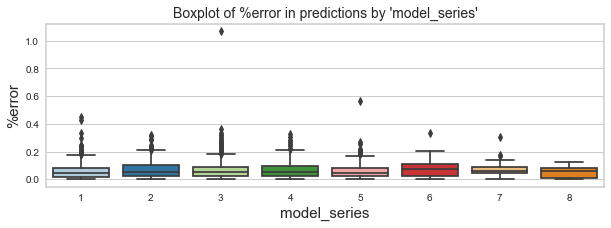

In [890]:
pred_without_outlier = predicted_cat_reg_tuned[predicted_cat_reg_tuned['%error']<3]
plt.figure(figsize=(10,3))
sns.boxplot(x='model_series', y = '%error', data = pred_without_outlier)
plt.title("Boxplot of %error in predictions by 'model_series'", fontsize=14)
plt.show()

From boxplot we can see that for all model series 75% of predictions have error about 10% or less, but there are many outliers in `%error` column. For 8 model series the interquartile range is the widest, but `%error` median is low and there are no outliers for this model line. The highest median of `%error` is for 6 model series.

In [632]:
print('{}% of predictions have error above 10% and {}% have error above 15%.'.format(
    round(predicted_cat_reg_reduced_features_31[predicted_cat_reg_reduced_features_31['%error']>0.10].Real_price.count()/
          predicted_cat_reg_reduced_features_31.Real_price.count(), 4)*100,
    round(predicted_cat_reg_reduced_features_31[predicted_cat_reg_reduced_features_31['%error']>0.15].Real_price.count()/
          predicted_cat_reg_reduced_features_31.Real_price.count(), 4)*100
))

21.46% of predictions have error above 10% and 8.76% have error above 15%.


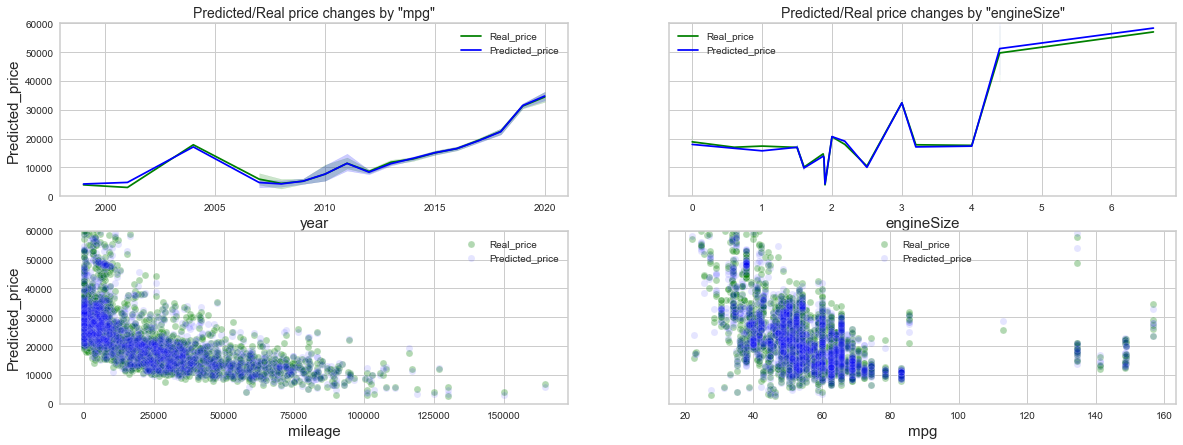

In [741]:
# Plot new '%error'  and predictions in context with other most important features
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,7), sharey=True)
sns.lineplot(x='year', y='Real_price', data = pred_without_outlier, color='green', ax=axs[0, 0], 
             label="Real_price")
sns.lineplot(x='year', y='Predicted_price', data = pred_without_outlier, color='blue', ax=axs[0, 0],
             label="Predicted_price")
sns.lineplot(x='engineSize', y='Real_price', data = pred_without_outlier, color='green',  ax=axs[0, 1], 
             label="Real_price")
sns.lineplot(x='engineSize', y='Predicted_price', data = pred_without_outlier, color='blue',  ax=axs[0, 1],
             label="Predicted_price")
sns.scatterplot(x='mileage', y='Real_price', data = pred_without_outlier, color='green', alpha=0.3, ax=axs[1, 0], 
                label="Real_price")
sns.scatterplot(x='mileage', y='Predicted_price', data = pred_without_outlier, color='blue', alpha=0.1, ax=axs[1, 0], 
                label="Predicted_price")
sns.scatterplot(x='mpg', y='Real_price', data = pred_without_outlier, color='green', alpha=0.3, ax=axs[1, 1], 
                label="Real_price")
sns.scatterplot(x='mpg', y='Predicted_price', data = pred_without_outlier, color='blue', alpha=0.1, ax=axs[1, 1], 
                label="Predicted_price")
axs[0, 0].set_ylim((0,60000))
axs[0, 1].set_ylim((0,60000))
axs[0, 0].set_title('Predicted/Real price by "year"', fontsize=14)
axs[0, 1].set_title('Predicted/Real price changes by "engineSize"', fontsize=14)
axs[0, 0].set_title('Predicted/Real price changes by "mileage"', fontsize=14)
axs[0, 0].set_title('Predicted/Real price changes by "mpg"', fontsize=14)
plt.show()

Figures show that there are deviations of predicted price from the real price for the older cars (approximately older than 2007) and there is a wider interval of confidence in predictions for cars that were produced in about 2009-2012. This can be connected to the fact that there is not much data for the older cars. 

As for figures with `mileage` and `mpg` features – seems like predictions are more conservative in comparison to real observations and algorithm does not catch some of the most extreme cases with very low or high features values.

## 11. Implement BMW used cars predictor using CatBoostRegressor algorithm <a name="6.9"></a>

In this section we will define a function which predicts car price and will test it on some real world examples from the web site https://www.autotrader.co.uk.

In [899]:
# Define function to predict cars prices
def predict_car_price (model: object, year: int, transmission: object, mileage, fuelType: object, tax: int, mpg: float, 
                       engineSize: float, prediction_model=cat_reg_tuned):
    
    car = pd.DataFrame({'model': [model], 'year': int(year), 'transmission': [transmission], 'mileage': int(mileage), 
                        'fuelType': [fuelType], 'tax': int(tax), 'mpg': float(mpg), 'engineSize': float(engineSize)})
    # Add features
    create_engine_category (data=car)
    create_model_group_and_series (data=car)
    create__big_engine_auto_semi_auto (data=car)
    create__not_old_car (data=car)
    create_mpg_1_and_mpg_2 (data=car)
    # Scale and encode fetures, combine preprocces features 
    car_num = scaler.transform(car.select_dtypes(exclude='object'))
    cart_cat = encoder.transform(car.select_dtypes(include='object'))
    car_processed = np.concatenate((car_num, cart_cat.toarray()), axis=1)
    predcition = prediction_model.predict(car_processed)
    return car, predcition

In [900]:
# Prepare input data
cars = [{'model': '2 Series',  'year': 2017,  'transmission':  'Automatic',  'mileage': 31000, 'fuelType': 'Diesel', 'tax': 155, 
         'mpg': 48.7, 'engineSize': 2}, 
        {'model': 'X3',  'year': 2016,  'transmission':  'Automatic',  'mileage': 40500, 'fuelType': 'Diesel',  'tax': 155, 
         'mpg': 49.6, 'engineSize': 2}, 
        {'model': 'M4',  'year': 2017,  'transmission':  'Automatic',  'mileage': 45884, 'fuelType': 'Diesel',  'tax': 155, 
         'mpg': 46.3, 'engineSize': 2}, 
        {'model': '3 Series',  'year': 2016,  'transmission':  'Manual',  'mileage': 41351, 'fuelType': 'Petrol',  'tax': 130, 
         'mpg': 45.6, 'engineSize': 1.5}]

real_samples = pd.DataFrame.from_dict({'https://www.autotrader.co.uk/car-details/202104281944760': [17000],
              'https://www.autotrader.co.uk/car-details/202104281946523': [18990],
              'https://www.autotrader.co.uk/car-details/202104291960876': [21000],
              'https://www.autotrader.co.uk/car-details/202104291961070': [11500]}, orient='index', columns=['real_price'])

In [901]:
#Make a prediction of prices with tuned version of CatBoostRegressor and with first version of CatBoostRegressor trained with transformed target (MAE for this model was smaller)
real_samples['predicted_price'] = np.arange(0, 4)
for num, i in enumerate(cars):
    _, value = predict_car_price(**i, prediction_model=cat_reg_tuned)
    real_samples.iloc[num, 1] = np.round(value)

In [902]:
display(real_samples)
# Calculate  metrics for version without transformation 
calculate_metrics(y_pred=real_samples.predicted_price, model=cat_reg, y=real_samples.real_price)

,real_price,predicted_price
https://www.autotrader.co.uk/car-details/202104281944760,17000,16646.0
https://www.autotrader.co.uk/car-details/202104281946523,18990,18815.0
https://www.autotrader.co.uk/car-details/202104291960876,21000,21328.0
https://www.autotrader.co.uk/car-details/202104291961070,11500,13844.0


Results of <catboost.core.CatBoostRegressor object at 0x0000024560AE6D60> model: 
 - explained_variance: 0.9081,
 - mean_absolute_error: 800.25, 
 - root_mean_squared_error: 1199.7772, 
 - mean_squared_log_error: 0.008794.


The sample for this test is not large enough to make any conclusions, but surprisingly RMSE and MSE for these 4 examples is even smaller than on the testing set. It's recommended to test the model on the bigger sample of real data.

## 11. Conclusion and Recommendations <a name="7"></a>

The aim of this project was to explore what factors affect used cars price the most and to implement a prototype of used BMW cars price predictor which can assist the potential buyers and sellers to define a fair price of a car with minimal time efforts.

### Exploration of what factors affect a price of used BMW cars

The results on the test set show that only 8 parameters are able to explain almost 96% of variance in price:
-	Year when car was produced (importance_score – 30.8);
-	Number in model name (importance_score – 17);
-	Mileage (importance_score – 16.7);
-	Mileage per gallon parameter (importance_score – 12);
-	Added feature `_big_engine_auto_semi_auto` which is a boolean parameter which is True when a car has automatic or semi-automatic transmission and engine size above 2.9 liters (importance_score – 7.9);
-	Boolean parameter which is True when a car belongs to `X` model line (importance_score – 7.9);
-	Size of engine in liters (importance_score – 4.4);
-	Added feature `mpg_2` which is filled if ` fuelType` is ` Diesel` (importance_score – 3.4).

In other words we can conclude that all the features except `tax`, that were in the initial dataset proved are important for price prediction: `year`, `model`, `mileage`, `mpg`, `transmission`, `engineSize` and `fuelType`. 

### Prototype of price predictor for used BMW cars 

In this project several machine learning algorithms were tested and different data preprocessing approaches were explored. New features were extracted from the initial data. Data was spit into training (80%) and testing (20%) set.

The best results were received by the predictive model based on CatBoostRegressor algorithm.
The results on the test set were:
 - explained_variance: 0.9631,
 - mean_absolute_error: 1472.1143, 
 - root_mean_squared_error: 2204.1986, 
 - mean_squared_log_error: 0.008718.

To check the model performance on the real data, 4 inputs of samples from [autotrader.co.uk](https://www.autotrader.co.uk) web-site were manually added and price were predicted for them. The results we got are RMSE of £977 and MAE of £773.5 which is better than on training or testing set.

The sample size for this test is not large enough to make any conclusions, so it's recommended to check model performance on the bigger sample and analyze the results.


**Limitations of the price prediction model:**
1.	The of the best performing model that we got on the test set are: mean absolute error of £1473  and mean squared error of £2204. There are about 21% of predictions that have error above 10% and almost 9% of predictions have error above 15%. It’s important to define what are minimal requirements for the model performance, because the current model's predictions might not be reliable enough.
2.	There are outliers in target variable price that are not explained by the parameters that we have in the dataset.
3.	CatBoostRegressor algorithm provided the best results on the test set, but is more computationally expensive than other simpler algorithms with slightly bigger loss. Amount of data to be processed and the expected execution time should be taken into consideration when applying price prediction model.
4.	Cars sales data quickly gets irrelevant with time: demand on the market changes, new models are released and with each time period cars loose in value because their age increases, etc. The price predictor should be updated regularly to provide relevant predictions.

**Possible ways to improve performance of the model:**

1.	Explore in greater depth hyperparameter tuning for CatBoostRegressor. However it is not very likely that much of improvement can be achieved by performing this.
2.	In the dataset some values of real price does not make sense judging from the parameters known about a car. It’s possible that more information about cars can be retrieved that can explain unclear variance in price, for example: 
    -	assessment of car condition, 
    -	more information about important car characteristics (engine model, color, if navigation is installed, leather/textile interior, if car is convertible, number of doors, etc),
    -	information about additional packages/additions installed in a car or assessment of value of additions/packages,
    -	location, 
    -	if a car was in accident and what was a severity of damage, etc. 
3. Collect more data (for example in the dataset there is not much data for the older cars).
4. Explore model performance on the real unseen data and tune it in accordance to received results.

## 12. References <a name="8"></a>


- (1) [Car depreciation](https://www.theaa.com/car-buying/depreciation)
- (2) [DataCamp GitHub repository for careerhub data](https://github.com/datacamp/careerhub-data/tree/master/BMW%20Used%20Car%20Sales)
- (3) [The Society of Motor Manufacturers and Traders.Used car sales: Q1 2020](https://www.smmt.co.uk/2020/05/used-car-sales-q1-2020/)
- (4) [The Society of Motor Manufacturers and Traders.Used car sales: Q2 2020](https://www.smmt.co.uk/2020/08/used-car-sales-q2-2020/)
- (5) [The Society of Motor Manufacturers and Traders.Used car sales: Q3 2020](https://www.smmt.co.uk/2020/11/used-car-sales-q3-2020/)
- (6) [The Society of Motor Manufacturers and Traders.Used car sales: Q4 2020](https://www.smmt.co.uk/2021/02/used-car-sales-q4-2020/)
- (7) [Monthly BMW car market share in the United Kingdom (UK) from January 2015 to December 2020](https://www.statista.com/statistics/300446/bmw-car-market-share-in-the-united-kingdom/)
- (8) [Monthly sales volume of BMW passenger cars in the United Kingdom (UK) from January 2019 to December 2020](https://www.statista.com/statistics/300405/bmw-car-sales-in-the-united-kingdom/)
- (9) [The Ultimate List of UK Car Stats 2020](https://www.carmoney.co.uk/blog/the-ultimate-list-of-uk-car-stats)
- (10) [Linear regression assumptions](https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45)
- (11) [BMW 3-Series running costs and mpg](https://www.parkers.co.uk/bmw/3-series/review/mpg-running-costs/)
- (12) [Calculation of MPG for Hybrid Electric Vehicles](https://www.epa.gov/fueleconomy/plug-hybrid-electric-vehicle-learn-more-about-new-label)
- (13) [Honest John. Detailed reviews of new and used cars. Real MPG of BMW M6 model](https://www.honestjohn.co.uk/realmpg/bmw/m6-2012)
- (14) [Wikipedia. BMW i3 model](https://en.wikipedia.org/wiki/BMW_i3)
- (15) [Understanding BMW naming conventions](https://cartelligent.com/blog/understanding-bmw-naming-conventions)
- (16) [Deep Dive into Catboost Functionalities for Model Interpretation](https://towardsdatascience.com/deep-dive-into-catboost-functionalities-for-model-interpretation-7cdef669aeed)
    